# Chained deep learning using generalized cross entropy for multiple annotators segmentation



## Loss functions for segmentation in deep learning


Given a $k$ class multiple annotators segmentation problem with a dataset like the following'

$$\mathbf X \in \mathbb{R}^{W \times H}, \{ \mathbf Y_r \in \{0,1\}^{W \times H \times K} \}_{r=1}^R; \;\; \mathbf {\hat Y} \in [0,1]^{W\times H \times K} = f(\mathbf X)$$

The segmentation mask function will map input output as follows:

$$f: \mathbb  R ^{W\times H} \to [0,1]^{W\times H\times K}$$

$\mathbf Y$ will satisfy the following condition for being a softmax-like representation:

$$\mathbf Y_r[w,h,:] \mathbf{1} ^ \top _ k = 1; \;\; w \in W, h \in H$$

Now, let's suppose the existence of an annotators reliability map estimation $\Lambda_r; \; r \in R$;


$$\bigg\{ \Lambda_r (\mathbf X; \theta ) \in [0,1] ^{W\times H} \bigg\}_{r=1}^R $$


Then, our $TGCE_{SS}$:


$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \mathbf{\Lambda}_r (\mathbf X;\theta)) =\mathbb E_{r} \left\{ \mathbb E_{w,h}  \left\{ \Lambda_r (\mathbf X; \theta) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \Lambda _r (\mathbf X;\theta)\right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$


Where $q \in (0,1)$

Total Loss for a given batch holding $N$ samples:

$$\mathscr{L}\left(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta)\right)  = \frac{1}{N} \sum_{n}^NTGCE_{SS}(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta))$$

## Modification of Keras Tuner bayesian optimization with a Matern kernel with Nu ($\nu$) value 0.5

In [1]:
import os
new_content="""
# Copyright 2019 The KerasTuner Authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np

try:
    import sklearn
    import sklearn.exceptions
    import sklearn.gaussian_process
except ImportError:  # pragma: no cover
    sklearn = None  # pragma: no cover

try:
    import scipy
    import scipy.optimize
except ImportError:  # pragma: no cover
    scipy = None  # pragma: no cover

from keras_tuner.src.api_export import keras_tuner_export
from keras_tuner.src.engine import hyperparameters as hp_module
from keras_tuner.src.engine import oracle as oracle_module
from keras_tuner.src.engine import trial as trial_module
from keras_tuner.src.engine import tuner as tuner_module


@keras_tuner_export("keras_tuner.oracles.BayesianOptimizationOracle")
class BayesianOptimizationOracle(oracle_module.Oracle):
    \"\"\"Bayesian optimization oracle.

    It uses Bayesian optimization with a underlying Gaussian process model.
    The acquisition function used is upper confidence bound (UCB), which can
    be found [here](
    https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf).

    Args:
        objective: A string, `keras_tuner.Objective` instance, or a list of
            `keras_tuner.Objective`s and strings. If a string, the direction of
            the optimization (min or max) will be inferred. If a list of
            `keras_tuner.Objective`, we will minimize the sum of all the
            objectives to minimize subtracting the sum of all the objectives to
            maximize. The `objective` argument is optional when
            `Tuner.run_trial()` or `HyperModel.fit()` returns a single float as
            the objective to minimize.
        max_trials: Integer, the total number of trials (model configurations)
            to test at most. Note that the oracle may interrupt the search
            before `max_trial` models have been tested if the search space has
            been exhausted. Defaults to 10.
        num_initial_points: Optional number of randomly generated samples as
            initial training data for Bayesian optimization. If left
            unspecified, a value of 3 times the dimensionality of the
            hyperparameter space is used.
        alpha: Float, the value added to the diagonal of the kernel matrix
            during fitting. It represents the expected amount of noise in the
            observed performances in Bayesian optimization. Defaults to 1e-4.
        beta: Float, the balancing factor of exploration and exploitation. The
            larger it is, the more explorative it is. Defaults to 2.6.
        seed: Optional integer, the random seed.
        hyperparameters: Optional `HyperParameters` instance. Can be used to
            override (or register in advance) hyperparameters in the search
            space.
        tune_new_entries: Boolean, whether hyperparameter entries that are
            requested by the hypermodel but that were not specified in
            `hyperparameters` should be added to the search space, or not. If
            not, then the default value for these parameters will be used.
            Defaults to True.
        allow_new_entries: Boolean, whether the hypermodel is allowed to
            request hyperparameter entries not listed in `hyperparameters`.
            Defaults to True.
        max_retries_per_trial: Integer. Defaults to 0. The maximum number of
            times to retry a `Trial` if the trial crashed or the results are
            invalid.
        max_consecutive_failed_trials: Integer. Defaults to 3. The maximum
            number of consecutive failed `Trial`s. When this number is reached,
            the search will be stopped. A `Trial` is marked as failed when none
            of the retries succeeded.
    \"\"\"

    def __init__(
        self,
        objective=None,
        max_trials=10,
        num_initial_points=None,
        alpha=1e-4,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        allow_new_entries=True,
        tune_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
    ):
        if scipy is None:
            raise ImportError(
                "Please install scipy before using the `BayesianOptimization` "
                "with `pip install keras-tuner[bayesian]`."
            )

        if sklearn is None:
            raise ImportError(
                "Please install scikit-learn (sklearn) before using the "
                "`BayesianOptimization` with "
                "`pip install keras-tuner[bayesian]`."
            )
        super().__init__(
            objective=objective,
            max_trials=max_trials,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            seed=seed,
            max_retries_per_trial=max_retries_per_trial,
            max_consecutive_failed_trials=max_consecutive_failed_trials,
        )
        self.num_initial_points = num_initial_points
        self.alpha = alpha
        self.beta = beta
        self._random_state = np.random.RandomState(self.seed)
        self.gpr = self._make_gpr()

    def _make_gpr(self):
        return sklearn.gaussian_process.GaussianProcessRegressor(
            kernel=sklearn.gaussian_process.kernels.Matern(nu=0.5),
            n_restarts_optimizer=20,
            normalize_y=True,
            alpha=self.alpha,
            random_state=self.seed,
        )

    def populate_space(self, trial_id):
        \"\"\"Fill the hyperparameter space with values.

        Args:
            trial_id: A string, the ID for this Trial.

        Returns:
            A dictionary with keys "values" and "status", where "values" is
            a mapping of parameter names to suggested values, and "status"
            should be one of "RUNNING" (the trial can start normally), "IDLE"
            (the oracle is waiting on something and cannot create a trial), or
            "STOPPED" (the oracle has finished searching and no new trial should
            be created).
        \"\"\"
        # Generate enough samples before training Gaussian process.
        completed_trials = [
            t for t in self.trials.values() if t.status == "COMPLETED"
        ]

        # Use 3 times the dimensionality of the space as the default number of
        # random points.
        dimensions = len(self.hyperparameters.space)
        num_initial_points = self.num_initial_points or max(3 * dimensions, 3)
        if len(completed_trials) < num_initial_points:
            return self._random_populate_space()

        # Fit a GPR to the completed trials and return the predicted optimum
        # values.
        x, y = self._vectorize_trials()

        # Ensure no nan, inf in x, y. GPR cannot process nan or inf.
        x = np.nan_to_num(x, posinf=0, neginf=0)
        y = np.nan_to_num(y, posinf=0, neginf=0)

        self.gpr.fit(x, y)

        def _upper_confidence_bound(x):
            x = x.reshape(1, -1)
            mu, sigma = self.gpr.predict(x, return_std=True)
            return mu - self.beta * sigma

        optimal_val = float("inf")
        optimal_x = None
        num_restarts = 50
        bounds = self._get_hp_bounds()
        x_seeds = self._random_state.uniform(
            bounds[:, 0], bounds[:, 1], size=(num_restarts, bounds.shape[0])
        )
        for x_try in x_seeds:
            # Sign of score is flipped when maximizing.
            result = scipy.optimize.minimize(
                _upper_confidence_bound,
                x0=x_try,
                bounds=bounds,
                method="L-BFGS-B",
            )
            result_fun = (
                result.fun if np.isscalar(result.fun) else result.fun[0]
            )
            if result_fun < optimal_val:
                optimal_val = result_fun
                optimal_x = result.x

        values = self._vector_to_values(optimal_x)
        return {"status": trial_module.TrialStatus.RUNNING, "values": values}
    
    def _gpr_trained(self):
        if self.gpr is None:
            print("There is no GPR model trained yet.")
            return None
        else:
            return self.gpr

    def _random_populate_space(self):
        values = self._random_values()
        if values is None:
            return {"status": trial_module.TrialStatus.STOPPED, "values": None}
        return {"status": trial_module.TrialStatus.RUNNING, "values": values}

    def get_state(self):
        state = super().get_state()
        state.update(
            {
                "num_initial_points": self.num_initial_points,
                "alpha": self.alpha,
                "beta": self.beta,
            }
        )
        return state

    def set_state(self, state):
        super().set_state(state)
        self.num_initial_points = state["num_initial_points"]
        self.alpha = state["alpha"]
        self.beta = state["beta"]
        self.gpr = self._make_gpr()

    def _vectorize_trials(self):
        x = []
        y = []
        ongoing_trials = set(self.ongoing_trials.values())
        for trial in self.trials.values():
            # Create a vector representation of each Trial's hyperparameters.
            trial_hps = trial.hyperparameters
            vector = []
            for hp in self._nonfixed_space():
                # For hyperparameters not present in the trial (either added
                # after the trial or inactive in the trial), set to default
                # value.
                if (
                    trial_hps.is_active(hp)  # inactive
                    and hp.name in trial_hps.values  # added after the trial
                ):
                    trial_value = trial_hps.values[hp.name]
                else:
                    trial_value = hp.default

                # Embed an HP value into the continuous space [0, 1].
                prob = hp.value_to_prob(trial_value)
                vector.append(prob)

            if trial in ongoing_trials:
                # "Hallucinate" the results of ongoing trials. This ensures that
                # repeat trials are not selected when running distributed.
                x_h = np.array(vector).reshape((1, -1))
                y_h_mean, y_h_std = self.gpr.predict(x_h, return_std=True)
                # Give a pessimistic estimate of the ongoing trial.
                y_h_mean = np.array(y_h_mean).flatten()
                score = y_h_mean[0] + y_h_std[0]
            elif trial.status == "COMPLETED":
                score = trial.score
                # Always frame the optimization as a minimization for
                # scipy.minimize.
                if self.objective.direction == "max":
                    score = -1 * score
            elif trial.status in ["FAILED", "INVALID"]:
                # Skip the failed and invalid trials.
                continue

            x.append(vector)
            y.append(score)

        x = np.array(x)
        y = np.array(y)
        return x, y

    def _vector_to_values(self, vector):
        hps = hp_module.HyperParameters()
        vector_index = 0
        for hp in self.hyperparameters.space:
            hps.merge([hp])
            if isinstance(hp, hp_module.Fixed):
                value = hp.value
            else:
                prob = vector[vector_index]
                vector_index += 1
                value = hp.prob_to_value(prob)

            if hps.is_active(hp):
                hps.values[hp.name] = value
        return hps.values

    def _nonfixed_space(self):
        return [
            hp
            for hp in self.hyperparameters.space
            if not isinstance(hp, hp_module.Fixed)
        ]

    def _get_hp_bounds(self):
        bounds = [[0, 1] for _ in self._nonfixed_space()]
        return np.array(bounds)


@keras_tuner_export(
    [
        "keras_tuner.BayesianOptimization",
        "keras_tuner.tuners.BayesianOptimization",
    ]
)
class BayesianOptimization(tuner_module.Tuner):
    \"\"\"BayesianOptimization tuning with Gaussian process.

    Args:
        hypermodel: Instance of `HyperModel` class (or callable that takes
            hyperparameters and returns a `Model` instance). It is optional
            when `Tuner.run_trial()` is overridden and does not use
            `self.hypermodel`.
        objective: A string, `keras_tuner.Objective` instance, or a list of
            `keras_tuner.Objective`s and strings. If a string, the direction of
            the optimization (min or max) will be inferred. If a list of
            `keras_tuner.Objective`, we will minimize the sum of all the
            objectives to minimize subtracting the sum of all the objectives to
            maximize. The `objective` argument is optional when
            `Tuner.run_trial()` or `HyperModel.fit()` returns a single float as
            the objective to minimize.
        max_trials: Integer, the total number of trials (model configurations)
            to test at most. Note that the oracle may interrupt the search
            before `max_trial` models have been tested if the search space has
            been exhausted. Defaults to 10.
        num_initial_points: Optional number of randomly generated samples as
            initial training data for Bayesian optimization. If left
            unspecified, a value of 3 times the dimensionality of the
            hyperparameter space is used.
        alpha: Float, the value added to the diagonal of the kernel matrix
            during fitting. It represents the expected amount of noise in the
            observed performances in Bayesian optimization. Defaults to 1e-4.
        beta: Float, the balancing factor of exploration and exploitation. The
            larger it is, the more explorative it is. Defaults to 2.6.
        seed: Optional integer, the random seed.
        hyperparameters: Optional `HyperParameters` instance. Can be used to
            override (or register in advance) hyperparameters in the search
            space.
        tune_new_entries: Boolean, whether hyperparameter entries that are
            requested by the hypermodel but that were not specified in
            `hyperparameters` should be added to the search space, or not. If
            not, then the default value for these parameters will be used.
            Defaults to True.
        allow_new_entries: Boolean, whether the hypermodel is allowed to
            request hyperparameter entries not listed in `hyperparameters`.
            Defaults to True.
        max_retries_per_trial: Integer. Defaults to 0. The maximum number of
            times to retry a `Trial` if the trial crashed or the results are
            invalid.
        max_consecutive_failed_trials: Integer. Defaults to 3. The maximum
            number of consecutive failed `Trial`s. When this number is reached,
            the search will be stopped. A `Trial` is marked as failed when none
            of the retries succeeded.
        **kwargs: Keyword arguments relevant to all `Tuner` subclasses. Please
            see the docstring for `Tuner`.
    \"\"\"

    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        num_initial_points=None,
        alpha=1e-4,
        beta=2.6,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        max_retries_per_trial=0,
        max_consecutive_failed_trials=3,
        **kwargs
    ):
        oracle = BayesianOptimizationOracle(
            objective=objective,
            max_trials=max_trials,
            num_initial_points=num_initial_points,
            alpha=alpha,
            beta=beta,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            max_retries_per_trial=max_retries_per_trial,
            max_consecutive_failed_trials=max_consecutive_failed_trials,
        )
        super().__init__(oracle=oracle, hypermodel=hypermodel, **kwargs)
"""

file_path = "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/tuners/bayesian.py"

with open(file_path, 'w') as file:
    file.write(new_content)

## Download and importing of libraries

In [2]:
%%capture
!pip install --upgrade keras==2.15.0
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null

In [3]:
# General Libraries
import time
import shutil
import random
import warnings
import pandas as pd
import seaborn as sns
from enum import auto, Enum
from functools import partial
from datetime import datetime

# Image Processing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras_tuner import Objective
from keras_tuner import HyperModel
import tensorflow.keras.backend as K
from keras.layers import Layer, Activation
from keras_tuner import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_custom_objects
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Machine Learning Libraries - Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, DotProduct, ExpSineSquared, Matern

# Deep Learning Libraries - GCPDS
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet

# Deep Learning Libraries - TensorFlow specific
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras import Model, layers, regularizers

# Other Libraries
import gc
import json
import gdown
import itertools
from PIL import ImageFont
from dataclasses import dataclass
from matplotlib.style import available
from tensorflow.python.framework.ops import EagerTensor

warnings.filterwarnings("ignore") # Disable warnings

2024-06-18 04:59:36.497440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 04:59:36.497567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 04:59:36.610793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download OxfordPet dataset and generation of synthetic annotators with the introduction of different signal-to-noise ratio values

In [4]:
# Download OxfordPet dataset

dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete1WBXC0/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete1WBXC0/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
# Download trained Unet network for OxfordPet segmentation task from Drive

model_url = "https://drive.google.com/file/d/1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G/view?usp=drive_link"
model_uri = model_url.split("/")[5]
!gdown $model_uri

model_extension = "keras"
paths = []

for file in os.listdir("."):
  if file.endswith(model_extension):
    paths.append(file)

model_path = paths[0]
print(f"Loading {model_path}...")
model_ann  = tf.keras.models.load_model(model_path, compile = False)

Downloading...
From: https://drive.google.com/uc?id=1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G
To: /kaggle/working/oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice_826.keras
100%|███████████████████████████████████████| 6.24M/6.24M [00:00<00:00, 154MB/s]
Loading oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice_826.keras...


In [6]:
# Find last encoder convolution layer

def find_last_encoder_conv_layer(model):
    '''
    Finds the index of the last convolutional layer in the encoder part of the model.

    Parameters:
    model (keras.Model): The Keras model to search for the last encoder convolutional layer.

    Returns:
    int: Index of the last convolutional layer in the encoder part of the model.
    '''

    last_conv_encoder_layer = 0
    for i,layer in enumerate(model.layers):
        if (isinstance(layer, keras.layers.Conv2D)):
          last_conv_encoder_layer = i
        if (isinstance(layer, keras.layers.UpSampling2D)):
          break
    return last_conv_encoder_layer

last_conv_encoder_layer = find_last_encoder_conv_layer(model_ann)
last_conv_encoder_layer

24

In [7]:
# Compute and add noise to the target layer

def compute_snr(signal: float, noise_std: float) -> float:
    """Compute the Signal-to-Noise Ratio (SNR) in decibels.

    The Signal-to-Noise Ratio (SNR) measures the ratio of the power of a signal to the
    power of background noise. Higher SNR values indicate a stronger signal relative to
    the noise.

    Parameters:
        signal (float): The signal power.
        noise_std (float): The standard deviation of the background noise.

    Returns:
        float: The Signal-to-Noise Ratio (SNR) in decibels.

    """
    return 10 * np.log10(np.mean(signal ** 2) / noise_std ** 2)

class SnrType(Enum):
    """Enumeration representing different types of Signal-to-Noise Ratio (SNR) scales.

    This enumeration defines two types of SNR scales: 'log' and 'linear'. These types
    indicate whether the SNR values are represented in logarithmic or linear scale.

    Attributes:
        log (int): Represents the logarithmic scale for SNR values.
        linear (int): Represents the linear scale for SNR values.

    """
    log = 0
    linear = 1

def add_noise_to_layer_weights(model, layer, noise_snr, snr_type: SnrType = SnrType.log, verbose=0):
    """Adds noise to the weights of a specified layer in the model.

    This function adds noise to the weights of a specified layer in the model,
    simulating a certain signal-to-noise ratio (SNR) either in linear or logarithmic scale.

    Parameters:
        model (tf.keras.Model): The model to modify.
        layer (int): Index of the layer whose weights will be modified.
        noise_snr (float): Desired signal-to-noise ratio (SNR) for the added noise.
        snr_type (SnrType): Type of SNR scale to use, either 'log' (logarithmic) or 'linear'.
            Defaults to SnrType.log.
        verbose (int): Verbosity mode. If greater than 0, prints information about the noise
            and signal powers. Defaults to 0.

    Returns:
        float: The computed signal-to-noise ratio (SNR) after adding noise to the layer weights.

    """
    layer_weights = model.layers[layer].get_weights()

    sig_power = np.mean(layer_weights[0] ** 2)

    if snr_type == SnrType.log:
        noise_power = sig_power / (10 ** (noise_snr / 10))
    elif snr_type == SnrType.linear:
        noise_power = sig_power / noise_snr

    noise_std = noise_power ** (1 / 2)

    snr = compute_snr(layer_weights[0], noise_std)

    if verbose > 0:
        print(f"Adding noise for SNR: {noise_snr}\n\n")
        print(f"Signal power: {sig_power}")
        print(f"Noise power: {noise_power}\n\n")

    for i in range(layer_weights[0].shape[0]):
        for j in range(layer_weights[0].shape[1]):
            layer_weights[0][i][j] += np.random.randn(128, 128) * noise_std

    model.layers[last_conv_encoder_layer].set_weights(layer_weights)
    return snr

In [8]:
# Define the signal-to-noise ratio values for each synthetic annotator
values_to_test = [20,0,-15]

# Creation of the different models and their perturbations starting from the base model
def produce_disturbed_models(values_to_test, base_model_path):
    """Produces a list of disturbed models by adding noise to layer weights.

    This function loads a base model from the specified path and creates disturbed
    versions of it by adding noise to the weights of a specified layer. The noise
    level is controlled by the values provided in the `values_to_test` list.

    Parameters:
        values_to_test (list): A list of values representing the noise levels to test.
        base_model_path (str): The file path to the base model to load.

    Returns:
        Tuple containing two lists:
            - List of disturbed models, each with noise added to layer weights.
            - List of Signal-to-Noise Ratio (SNR) values corresponding to each disturbed model.

    """
    snr_values = []
    models = []

    for value in values_to_test:
        model_ = tf.keras.models.load_model(base_model_path, compile=False)
        snr = add_noise_to_layer_weights(model_, last_conv_encoder_layer, value)
        snr_values.append(snr)
        models.append(model_)

    return models, snr_values


disturbance_models, snr_values = produce_disturbed_models(values_to_test, model_path)

In [9]:
# Disturbance processing with different SNR ratios values for each database partition using the modified networks

BATCH_SIZE = 128
TARGET_SHAPE = (128, 128)
ORIGINAL_MODEL_SHAPE = 256, 256
NUM_ANNOTATORS = 3

def disturb_mask(model, image, model_shape, target_shape):
    """Disturbs a segmentation mask using a neural network model.

    This function takes an input image and passes it through the given neural network model
    to generate a disturbed segmentation mask. The input image is resized to fit the model's
    input shape, and the output mask is resized to match the target shape.

    Parameters:
        model (tf.keras.Model): A neural network model used to disturb the segmentation mask.
        image (tf.Tensor): Input image tensor.
        model_shape (tuple): Shape of the input expected by the model.
        target_shape (tuple): Target shape for the disturbed segmentation mask.

    Returns:
        A disturbed segmentation mask tensor.

    """
    return tf.image.resize(model(tf.image.resize(image, model_shape)), target_shape)


def mix_channels(mask, num_annotators):
    """Mixes the channels of a segmentation mask.

    This function creates a new tensor by mixing the channels of the input segmentation mask.
    It is commonly used in scenarios where binary segmentation masks are represented with
    multiple channels, each indicating the annotation of a different annotator.

    Parameters:
        mask (tensor): Input segmentation mask tensor with shape (batch_size, height, width, channels).
        num_annotators (int): Number of annotators whose annotations are included in the mask.

    Returns:
        A tensor representing the mixed channels segmentation mask with shape
        (batch_size, height, width, num_annotators).

    """
    return tf.stack([mask, 1 - mask], axis=-2)


def add_noisy_annotators(img: EagerTensor, models, model_shape, target_shape) -> EagerTensor:
    """Adds noise from multiple annotators to an input image.

    This function applies noise to an input image from multiple annotator models,
    creating a set of noisy annotations. It iterates through each model in the
    provided list of models, applying noise to the input image based on the
    characteristics of each model.

    Parameters:
        img (EagerTensor): The input image to which noise will be added.
        models (list): A list of annotator models used to generate noise.
        model_shape: The shape of the model's output.
        target_shape: The target shape of the output annotations.

    Returns:
        EagerTensor: A tensor representing the noisy annotations generated by
        applying noise from multiple annotators to the input image.

    """
    return tf.transpose([disturb_mask(model, img, model_shape=model_shape, target_shape=target_shape) for model in models], [2, 3, 1, 4, 0])


def map_dataset_MA(dataset, target_shape, model_shape, batch_size, num_annotators):
    """Preprocesses a dataset for multi-annotator segmentation tasks.

    This function performs a series of mapping operations on the input dataset
    to prepare it for training or evaluation in a multi-annotator segmentation
    scenario. It resizes images and masks, adds noisy annotations, reshapes masks,
    mixes channels, and batches the data.

    Parameters:
        dataset (tf.data.Dataset): Input dataset containing images, masks, labels, and image IDs.
        target_shape (tuple): Desired shape for the images and masks after resizing.
        model_shape (tuple): Shape required by the segmentation model.
        batch_size (int): Size of the batches to create.
        num_annotators (int): Number of annotators providing annotations for each image.

    Returns:
        A preprocessed dataset ready for training or evaluation.

    """
    dataset_ = dataset.map(lambda img, mask, label, id_img: (img, mask),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (tf.image.resize(img, target_shape),
                                                tf.image.resize(mask, target_shape)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, add_noisy_annotators(tf.expand_dims(img, 0),
                                                                         disturbance_models,
                                                                         model_shape=model_shape,
                                                                         target_shape=target_shape)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, tf.reshape(mask, (mask.shape[0], mask.shape[1], 1, mask.shape[-1]))),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, mix_channels(mask, num_annotators)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img, mask: (img, tf.squeeze(mask, axis=2)),
                             num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.batch(batch_size)
    return dataset_



train = map_dataset_MA(
    train_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)
val = map_dataset_MA(
    val_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)

test = map_dataset_MA(
    test_dataset,
    target_shape=TARGET_SHAPE,
    model_shape=ORIGINAL_MODEL_SHAPE,
    batch_size=BATCH_SIZE,
    num_annotators=NUM_ANNOTATORS)

Mask shape: (128, 128, 128, 2, 3) (batch_size * h * w * k * r) Img shape (128, 128, 128, 3)


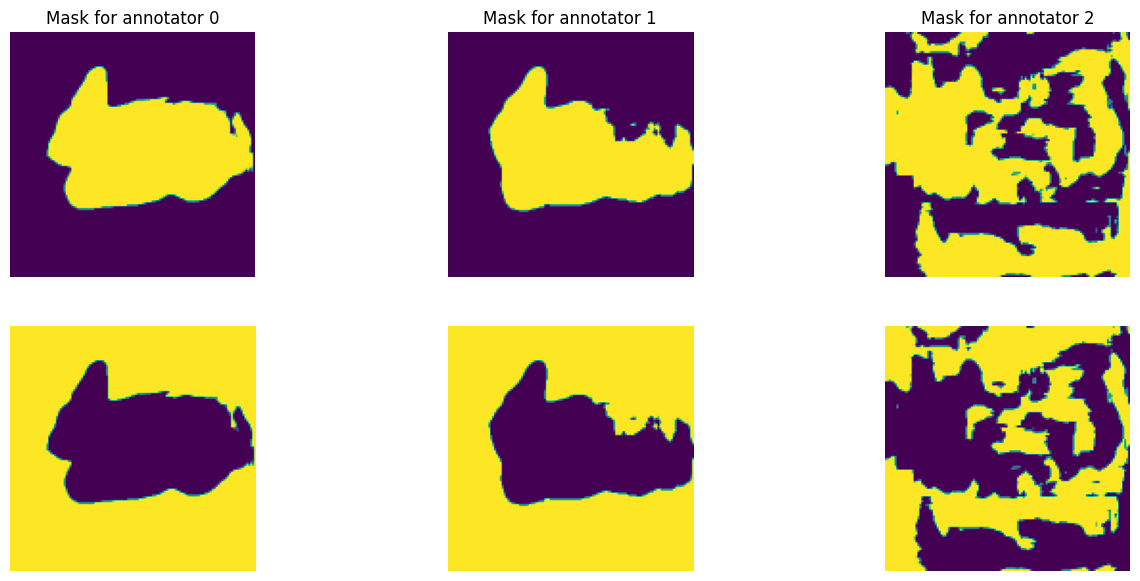

In [10]:
# Plotting the different perturbations to a sample and the resulting dimensions

for img,mask in train.take(1):
  print(f"Mask shape: {mask.shape} (batch_size * h * w * k * r) Img shape {img.shape}")
  fig, axes = plt.subplots(2,NUM_ANNOTATORS)
  fig.set_size_inches(16,7)
  for i in range(NUM_ANNOTATORS):
    axes[0][i].imshow((mask)[0,:,:,0,i])
    axes[0][i].set_title(f"Mask for annotator {i}")
    axes[0][i].axis('off')
    axes[1][i].imshow((mask)[0,:,:,-1,i])
    axes[1][i].axis('off')

## Loading of the different parts of the dataset

In [11]:
# Loading of the training part of the database in a tensor manner

X_train = []
y_train = []

for img, mask in train.take(8):
    img_1 = img
    mask_1 = mask
    X_train.append(img_1)
    y_train.append(tf.reshape(mask_1,[BATCH_SIZE, TARGET_SHAPE[0], TARGET_SHAPE[1], NUM_ANNOTATORS*2]))

X_train, y_train = tf.concat(X_train, axis=0), tf.concat(y_train, axis=0)
print(f'Tensor dimensions with training images: {X_train.shape} \nTensor dimensions with training masks: {y_train.shape}')

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Tensor dimensions with training images: (1024, 128, 128, 3) 
Tensor dimensions with training masks: (1024, 128, 128, 6)


In [12]:
# Loading of the validation part of the database in a tensor manner

X_val = []
y_val = []

for img, mask in val.take(2):
    img_1 = img
    mask_1 = mask
    X_val.append(img_1)
    y_val.append(tf.reshape(mask_1,[BATCH_SIZE, TARGET_SHAPE[0], TARGET_SHAPE[1], NUM_ANNOTATORS*2]))

X_val, y_val = tf.concat(X_val, axis=0), tf.concat(y_val, axis=0)
print(f'Tensor dimensions with validation images: {X_val.shape}\nTensor dimensions with validation masks: {y_val.shape}')

Tensor dimensions with validation images: (256, 128, 128, 3)
Tensor dimensions with validation masks: (256, 128, 128, 6)


In [13]:
# Loading of the testing part of the database in a tensor manner

X_test = []
y_test = []

for img, mask in test.take(2):
    img_1 = img
    mask_1 = mask
    X_test.append(img_1)
    y_test.append(tf.reshape(mask_1,[BATCH_SIZE, TARGET_SHAPE[0], TARGET_SHAPE[1], NUM_ANNOTATORS*2]))

X_test, y_test = tf.concat(X_test, axis=0), tf.concat(y_test, axis=0)
print(f'Tensor dimensions with test images: {X_test.shape}\nTensor dimensions with test masks: {y_test.shape}')

Tensor dimensions with test images: (256, 128, 128, 3)
Tensor dimensions with test masks: (256, 128, 128, 6)


## Loss for Tuned Gradual Class-wise Ensemble for Semi-supervised Learning

$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \mathbf{\Lambda}_r (\mathbf X;\theta)) =\mathbb E_{r} \left\{ \mathbb E_{w,h} \left\{  \Lambda_r (\mathbf X; \theta) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \Lambda _r (\mathbf X;\theta) \right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$

In [14]:
# Custom loss function: TGCE SS

class TGCE_SS(Loss):
    """Tuned Gradual Class-wise Ensemble for Semi-supervised Learning Loss.

    This loss function implements the Tuned Gradual Class-wise Ensemble (TGCE) loss for
    semi-supervised learning tasks. It is designed to improve the robustness of models
    against noisy annotations by considering the reliability of annotators. The loss function
    penalizes the disagreement between the model predictions and the ground truth labels,
    taking into account the reliability of annotators.

    Methods
    ----------
    call(y_true, y_pred)
    get_config()

    """

    def __init__(self, q=0.1, name='TGCE_SS', R=3, K_=2, smooth=1e-5, fill_channels=1, **kwargs):
        """Initializes the TGCE_SS loss object.

        Parameters:
            q (float): The tuning parameter for controlling the smoothness of the ensemble.
                Defaults to 0.1.
            name (str): Name of the loss function. Defaults to 'TGCE_SS'.
            R (int): Number of annotators. Defaults to NUM_ANNOTATORS.
            K_ (int): Number of classes. Defaults to 2.
            smooth (float): Smoothing parameter to avoid division by zero. Defaults to 1e-5.
            fill_channels (int): Number of filler channels. Defaults to 1.
            **kwargs: Additional arguments passed to the parent class.

        """
        self.q = q
        self.R = R
        self.K_ = K_
        self.smooth = smooth
        self.fill_channels = fill_channels
        super().__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        """Computes the TGCE_SS loss.

        Parameters:
            y_true (tensor): Ground truth labels.
            y_pred (tensor): Predicted probabilities.

        Returns:
            Containing the loss value.
        """
        y_pred = y_pred[..., :-self.fill_channels] # Disregarding backfill channels
        y_true = tf.reshape(y_true, tuple(y_true.shape[:-1])+(self.K_,self.R))
        Lambda_r = y_pred[..., self.K_:]  # Annotators reliability -> extra cnn upsampling layer
        y_pred_ = y_pred[..., :self.K_]  # Segmented images from unet
        N, W, H, _ = y_pred_.shape
        y_pred_ = y_pred_[..., tf.newaxis]
        y_pred_ = tf.repeat(y_pred_, repeats=[self.R], axis=-1)  # Repeat f(x)
        
        epsilon = 1e-8  # Small constant to avoid divisions by zero
        y_pred_ = tf.clip_by_value(y_pred_, epsilon, 1.0 - epsilon)  # Limiting values between epsilon and 1 - epsilon
        
        term_r = tf.math.reduce_mean(tf.math.multiply(y_true, (tf.ones([N, W, H, self.K_, self.R]) - tf.pow(y_pred_, self.q)) / (self.q + epsilon + self.smooth)), axis=-2)
        term_c = tf.math.multiply(tf.ones([N, W, H, self.R]) - Lambda_r, (tf.ones([N, W, H, self.R]) - tf.pow((1 / self.K_ + self.smooth) * tf.ones([N, W, H, self.R]), self.q)) / (self.q + epsilon + self.smooth))
        
        # Avoid NaN in final loss function
        TGCE_SS = tf.math.reduce_mean(tf.math.multiply(Lambda_r, term_r) + term_c)
        if tf.math.is_nan(TGCE_SS):
            TGCE_SS = tf.where(tf.math.is_nan(TGCE_SS), tf.constant(1e-8), TGCE_SS)  # Replace NaN with 1e-8
            print("\nInitializing TGCE_SS \n")
        
        return TGCE_SS / tf.constant(0.5857603) # Divided by the highest possible loss value        

    def get_config(self):
        """Gets the configuration of the loss function.

        Returns:
            A dictionary containing the configuration parameters of the loss function.

        """
        base_config = super().get_config()
        return {**base_config, "q": self.q}

## Definition of performance metrics

### DICE metric

$$\text{Dice} = {2 \cdot |\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i}$


- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a smoothing parameter to avoid division by zero.

In [15]:
# Definition of the DiceCoefficientMetric

def dice_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5, num_annotators=3):
    """Computes the Dice coefficient metric for evaluating semantic segmentation.

    This function calculates the Dice coefficient metric, which measures the similarity
    between ground truth and predicted segmentation masks.

    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axis along which to compute sums. Defaults to (1, 2).
        smooth (float): A smoothing parameter to avoid division by zero. Defaults to 1e-5.
        num_annotators (int): Number of annotators. Defaults to 3.

    Returns:
        A scalar value representing the average Dice coefficient metric.
    """
    channels =  [0, num_annotators]
    y_true = tf.gather(y_true, channels, axis=-1)
    y_pred = y_pred[...,:2]  
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

### Jaccard metric

$$\text{Jaccard} = {|\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i} - |\text{Intersection}|$
- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a small smoothing parameter to avoid division by zero.

In [16]:
# Definition of the JaccardMetric

def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5, num_annotators=3):
    """Computes the Jaccard similarity coefficient as a metric for semantic segmentation.

    The Jaccard similarity coefficient, also known as the Intersection over Union (IoU),
    measures the similarity between two sets by comparing their intersection to their union.
    In the context of semantic segmentation, it quantifies the overlap between the ground
    truth segmentation masks and the predicted segmentation masks.

    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axes along which to compute sums. Defaults to (1, 2).
        smooth (float): A small smoothing parameter to avoid division by zero. Defaults to 1e-5.
        num_annotators (int): Number of annotators. Defaults to 3.

    Returns:
        A tensor representing the mean Jaccard similarity coefficient.

    """
    channels =  [0, num_annotators]
    y_true = tf.gather(y_true, channels, axis=-1)
    y_pred = y_pred[...,:2]  
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)

### Sensitivity metric

$$\text{Sensitivity} = {\text{True Positives} \over \text{Actual Positives} + \text{smooth}}$$

Where:

$\text{True Positives} = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $\text{Actual Positives} = \sum_{i=1}^{N} y\_{true\_i}$


- $N$ is the total number of elements in the labels.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted labels, respectively.
- $\text{smooth}$ is a small value added to the denominator to avoid division by zero.

In [17]:
# Definition of the SensitivityMetric

def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5, num_annotators=3):
    """Computes the sensitivity as a metric for semantic segmentation.

    Sensitivity, also known as true positive rate or recall, measures the proportion
    of actual positives that are correctly identified by the model. It is computed
    as the ratio of true positives to the sum of true positives and false negatives.

    Parameters:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted probabilities or labels.
        axis (tuple): Axes over which to perform the reduction. Defaults to (1, 2).
        smooth (float): A small value added to the denominator to avoid division by zero. Defaults to 1e-5.
        num_annotators (int): Number of annotators. Defaults to 3.

    Returns:
        The sensitivity metric averaged over the specified axes.

    """
    channels =  [0, num_annotators]
    y_true = tf.gather(y_true, channels, axis=-1)
    y_pred = y_pred[...,:2]  
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + smooth)
    return tf.reduce_mean(sensitivity)

### Specificity metric

$$\text{Specificity} = {\text{True Negatives} \over \text{Actual Negatives} + \text{smooth}}$$

Where:

$\text{True Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i}) \cdot (1 - y\_{pred\_i})$, $\text{Actual Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i})$

- $N$ is the total number of samples.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the ground truth label and predicted probability (or binary prediction) for the i-th sample, respectively.
- $\text{smooth}$ is a smoothing term to avoid division by zero.

In [18]:
# Definition of the SpecificityMetric

def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5, num_annotators=3):
    """Computes the specificity as a metric for semantic segmentation.

    Specificity measures the proportion of actual negative cases that were correctly
    identified as such. It is complementary to sensitivity (recall).

    Parameters:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted probabilities or binary predictions.
        axis (tuple): Axes over which to perform reduction. Defaults to (1, 2).
        smooth (float): Smoothing term to avoid division by zero. Defaults to 1e-5.
        num_annotators (int): Number of annotators. Defaults to 3.

    Returns:
        A tensor representing the specificity metric.

    """
    channels =  [0, num_annotators]
    y_true = tf.gather(y_true, channels, axis=-1)
    y_pred = y_pred[...,:2] 
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + smooth)
    return tf.reduce_mean(specificity)

## Layers definition

In [19]:
# Definition of layers for the neural network structure

DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DilatedConv = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same", dilation_rate=10, name="DilatedConv")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)

upsample = partial(layers.UpSampling2D, (2,2))

## Kernel initializers

In [20]:
def kernel_initializer(seed):
    """Returns a Glorot uniform initializer for kernel weights.

    Glorot uniform initializer, also known as Xavier uniform initializer,
    is commonly used to initialize the weights of kernels in neural network layers.
    It draws samples from a uniform distribution within a certain range,
    calculated to keep the variance of the weights constant across layers.
    This initializer is useful for training deep neural networks.

    Parameters:
        seed (int): Random seed for reproducibility.

    Returns:
        A Glorot uniform initializer for kernel weights.

    """
    return tf.keras.initializers.GlorotUniform(seed=seed)

## Activation functions

### SparseSoftmax

$$\text{SparseSoftmax}(x) = \frac{\exp(x - \text{max}(x))}{\text{sum}(\exp(x - \text{max}(x)))}$$

Where:

- $x$ is the input tensor.
- $\text{max}(x)$ is the maximum value in the tensor $x$.
- $\text{sum}$ is the sum of the exponential values of $x - \text{max}(x)$.

In [21]:
class SparseSoftmax(Layer):
    """Custom layer implementing the sparse softmax activation function.

    This layer computes the softmax activation function for a given input tensor,
    handling sparse input efficiently.

    Methods
    ----------
    build(input_shape)
    call(x)
    compute_output_shape(input_shape)

    """

    def __init__(self, name='SparseSoftmax', **kwargs):
        """Initializes the SparseSoftmax layer.

        Parameters:
            **kwargs: Additional arguments to be passed to the parent class.

        """
        super(SparseSoftmax, self).__init__(name=name,**kwargs)

    def build(self, input_shape):
        """Builds the layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        """
        super(SparseSoftmax, self).build(input_shape)

    def call(self, x):
        """Computes the output of the layer.

        Parameters:
            x (tensor): Input tensor.

        Returns:
            A tensor representing the output of the softmax activation function.

        """
        e_x = K.exp(x - K.max(x, axis=-1, keepdims=True))
        sum_e_x = K.sum(e_x, axis=-1, keepdims=True)
        output = e_x / (sum_e_x + K.epsilon())
        return output

    def compute_output_shape(self, input_shape):
        """Computes the output shape of the layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        Returns:
            The same shape as the input tensor.

        """
        return input_shape

In [22]:
tf.keras.utils.get_custom_objects()['sparse_softmax'] = SparseSoftmax()

### Softmax bounded

$$\text{SoftmaxBounded}(x) = \text{softmax}(x) \cdot (\text{sup_limit} - \text{inf_limit}) + \text{inf_limit}$$

Where:

- $x$ is the input tensor.
- $\text{softmax}(x)$ denotes the standard softmax activation function applied to the input tensor $x$.
- $\text{sup_limit}$ is the upper limit of the output range.
- $\text{inf_limit}$ is the lower limit of the output range.

In [23]:
class SoftmaxCustom(Layer):
    """Custom layer that applies a modified softmax activation.

    This layer applies a softmax activation to the input tensor and scales the output
    values to lie within a specified range. It is particularly useful when you need
    to ensure that the output values of the softmax are within certain bounds.

    Methods
    ----------
    build(input_shape)
    call(x)
    compute_output_shape(input_shape)

    """

    def __init__(self, sup_limit=0.9, inf_limit=0.1, name='SoftmaxBounded',**kwargs):
        """Initializes the SoftmaxCustom layer.

        Parameters:
            sup_limit (float): The upper limit of the output range.
            inf_limit (float): The lower limit of the output range.
            **kwargs: Additional arguments passed to the parent class.

        """
        super(SoftmaxCustom, self).__init__(name=name,**kwargs)
        self.sup_limit = sup_limit
        self.inf_limit = inf_limit

    def build(self, input_shape):
        """Builds the SoftmaxCustom layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        """
        super(SoftmaxCustom, self).build(input_shape)

    def call(self, x):
        """Applies the modified softmax activation.

        Parameters:
            x (tensor): Input tensor.

        Returns:
            A tensor representing the output of the modified softmax activation.

        """
        return K.softmax(x) * (self.sup_limit - self.inf_limit) + self.inf_limit

    def compute_output_shape(self, input_shape):
        """Computes the output shape of the SoftmaxCustom layer.

        Parameters:
            input_shape (tuple): Shape of the input tensor.

        Returns:
            The same shape as the input tensor.

        """
        return input_shape

In [24]:
tf.keras.utils.get_custom_objects()['bounded_softmax'] = SoftmaxCustom()

### Visualization function

In [59]:
def plot_prediction(prediction,images,masks,num_img,num_annotators):
    """
    Plots the original image, its corresponding masks, and the predicted masks and confidence maps.

    This function helps in visualizing the performance of a model that predicts masks and confidence maps
    for a given image. It creates a 4x4 subplot grid, where the first row displays the original image, the second
    row shows the original and predicted masks for two channels, the third row displays the masks of each
    annotator, and the fourth row shows the confidence maps of each annotator.

    Parameters:
    prediction (tensor): A tensor of shape (B, H, W, C) containing the predicted masks and confidence maps,
                           where B is the batch size, H and W are the height and width of the image, and C is
                           the number of channels (2 channels for masks and C-2 channels for confidence maps).
    images (tensor): A tensor of shape (B, H, W, 3) containing the original RGB images.
    masks (tensor): A tensor of shape (B, H, W, C) containing the original masks annotated by C annotators.
    num_img (int): The index of the image in the batch to be plotted.
    num_annotators (int): The number of annotators.

    Returns:
    None. This function only displays the plots.
    """
    
    
    masks_annotators = masks
    channels = [0, num_annotators]
    masks = tf.gather(masks, channels, axis=-1)
    rows, columns = 4, 4
    fig, axes = plt.subplots(rows, columns, figsize=(20,10))
    
    # First row: original image
    axes[0, 0].imshow(images[num_img,...])
    axes[0, 0].set_title('Original image')
    
    # Second row: original masks and predicted masks
    axes[1, 0].imshow(masks[num_img,...,0])
    axes[1, 0].set_title('Original mask: Channel 0')
    axes[1, 1].imshow(masks[num_img,...,1])
    axes[1, 1].set_title('Original mask: Channel 1')
    axes[1, 2].imshow(prediction[0,...,0])
    axes[1, 2].set_title('Predicted mask: Channel 0')
    axes[1, 3].imshow(prediction[0,...,1])
    axes[1, 3].set_title('Predicted mask: Channel 1')
    
    # Third row: mask of each annotator for the image
    axes[2, 0].imshow(masks_annotators[num_img,...,0])
    axes[2, 0].set_title('Annotator 1 mask for image')
    axes[2, 1].imshow(masks_annotators[num_img,...,1])
    axes[2, 1].set_title('Annotator 2 mask for image')
    axes[2, 2].imshow(masks_annotators[num_img,...,2])
    axes[2, 2].set_title('Annotator 3 mask for image')
    
    # Fourth row: confidence maps of each annotator
    axes[3, 0].imshow(prediction[0,...,2],vmin=0.0,vmax=1.0)
    axes[3, 0].set_title('Confidence map annotator 1')
    axes[3, 1].imshow(prediction[0,...,3],vmin=0.0,vmax=1.0)
    axes[3, 1].set_title('Confidence map annotator 2')
    axes[3, 2].imshow(prediction[0,...,4],vmin=0.0,vmax=1.0)
    axes[3, 2].set_title('Confidence map annotator 3')
    
    # Off all axis
    [axes[i, k].axis('off') for i in range(rows) for k in range(columns)]

## Bayesian optimization of hyperparameters with Keras Tuner

In [26]:
class MetricsCallback(tf.keras.callbacks.Callback):
    """
    Custom Keras callback to log metrics at the end of training epochs.

    This callback logs metrics such as loss and accuracy at the end of each epoch
    during training. It stores the metrics in a global list `global_metrics` upon
    completion of the final epoch.

    Parameters:
        epochs (int): Total number of epochs for training.

    Methods:
        on_epoch_end(epoch, logs=None):
            Called at the end of each epoch. Logs metrics and stores them in
            `global_metrics` upon completion of the final epoch.
    """

    def __init__(self, epochs):
        """
        Initializes the MetricsCallback instance.

        Parameters:
            epochs (int): Total number of epochs for training.
        """
        super().__init__()
        self.epochs = epochs

    def on_epoch_end(self, epoch, logs=None):
        """
        Callback function called at the end of each epoch.

        Logs metrics such as loss and accuracy at the end of each epoch.
        Stores the metrics in `global_metrics` upon completion of the final epoch.

        Parameters:
            epoch (int): Current epoch number (0-indexed).
            logs (dict): Dictionary containing the metrics to log.
                Typically contains keys like 'loss' and 'accuracy'.
        """
        if epoch == self.epochs - 1:
            print(f"Final Epoch {epoch + 1}:")
            metrics_dict = {'epoch': epoch + 1}
            for key, value in logs.items():
                print(f"{key}: {value:.4f}")
                metrics_dict[key] = value
            global_metrics.append(metrics_dict)

![Unet-TGCELoss](https://lh3.googleusercontent.com/fife/ALs6j_FQpKDYXh1PSuK4B7zca2t-aLNDOGiHv3Cx4wnqrj5tDZp7LFygbkh3Pw0t3sIu7Fly0fC7BrL5I8HME3fXUAFPgKIkzPuTL8W1m6kBgaqQf8yMOt89R7PUO4PNgy0dG5DbixazOdTRquMcEzJ1WiYWf33c1gIK9_8eJhDmmhAYutY-HkMQBerxetLXEdSc2euRjPf7yKb44U9MwhfhX7UWt4Scndk6Pn6FQIczftrSXrAkpm1wQ3KqEuvtfRyffpoYAc48uZ2SYu9G22X9ZIyWBiGhQbuOe1MpW27lJ8SAtXcG5BIt6jy55NTFSWeh0AhuVM-3gwKhTOYqwy4C0lcbXQJ8XobTaWAQWxSyCPHkGfsccxwkILRi9-13j7Bd22ZReapWyu7w0Yrn4I2qxpvJ7kiVjElZWw8foKitEHsELCqLOKcJXrGQGr0qo9maTPzU_aLVYObrDrvndmdOSfkThd2hYswinp75TaoDSMOa3XJIK-02Rv9uS3S8w6VaWX3kggtxDeGlUyfLs8zBOj9SI0sZ8X8l0fd3nFUgOb1lTf29Eod57vzVICMMQvWO0sgabPavO7QxiMt5EvcJHrdZz0U1OYtC91SAszpd58JQSKPChrRaYjIiPNZPWdkFkztzFhClTMlgw8U6SUTSWHYJEDXFeb15Dnv4kNENTV0zpBT6PCdrdpqsNMnhGPGpaCeVPivt85Em8mz1I5YApYKKstjP-L5GG3cCSM3KSe2lu13cVZoBHDXAVUfmqlGgj37MGYsAi5V8U-S4G7Xtun40AYqxRC4OhptA2AdShQ6JOdPfKAlmhLy4rH9Ae1Euu3KrCcYuFY_-_x0POr45C7ouP5uyOAgtWDvM75yyAYkSBVqMYKV-VFnLW_piSQNsZiQXwqjiCGYTi4eYJVsn8TatuJW7o6L1MlO5qdtdgrWNN4lNTl1_CFB8b55wrzZgCxjuuUUGRKU1hA8cEtECtktWbUhfrwvgdCU7-fvuUMIZF7OBizlzGXQ-tYYbQjGpUzfSq19efU_9Wqj8Fep5fNRKuLRTLVP4d-GLy7ecoHbYR-bDx-Ln3oTiiEJ7n1_H6vrRskybpNN_eGhokwxNy3_9h2jWeEAxwWJn6tMf19lkpwdsYanf-VTp5SthSoWb7BA7_qGGXScorMXbbFlKGjAfYKLuXLapcO2wy1yvQe87fggoTkyECfNg_3ie_TdEZlmhdvjAX0oNNOFH6KOsck3WbRdB3cOyICd872hkS0QNB8TxdPVRAR_2ifRxBKOygqBYA0WKEVl2VPCnDDfmwJp401ORkk6AFEZssaKzWinP9Kt3Xo436vo_983b8oNLowlhfeJpHR9iWl9iaHxwU_LShYvCrG8L_eLeaPFAVVXgpPF31KGgeKOSFoaEDvO5OpMrPJ0HrDZPZSXw6KMNtf0B0t_1R6OJoD9OpJSAvUVrVd9xxnsVJxZGSGFr28MNrSJ1gl9PRPyLalFiakDhxYO2PwshZJrzf-GaUANkRx-lJpnzPkqlqcMxl1HNDYSnY73A3sb3kLJe7m_eq0EfCpJkTK4oNPF6-fS1YcQguS8BKnlMXdWfTTywv6Cjhb7ROe1qB83tCtU7syhVEuTzMohgcm-5jT-AOtGJX-WGQny3mboNKZU0j_y9sHAJD7UmTihwutj4Hr8eF1yFUbOTdw=w1632-h928)

In [27]:
def build_model_kt(hp: HyperParameters, input_shape=(128,128,3), name='UNET', out_channels=2, out_filler_channels=1,
                   out_ActFunction='sparse_softmax', n_scorers=3, out_ActFunction_Lambda='sparse_softmax'):
    """
    Builds a U-Net style model for image segmentation with hyperparameters tuned using Keras Tuner.

    This function constructs a U-Net architecture for semantic segmentation. It includes both the
    encoder and decoder parts with skip connections, and allows for hyperparameter tuning using
    Keras Tuner.

    Parameters:
        hp (HyperParameters): Keras Tuner HyperParameters object for defining tunable hyperparameters.
        input_shape (tuple): Shape of the input image tensor. Defaults to (128, 128, 3).
        name (str): Name of the model. Defaults to 'UNET'.
        out_channels (int): Number of output channels/classes for segmentation. Defaults to 2.
        out_filler_channels (int): Number of output filler channels. Defaults to 1.
        out_ActFunction (str): Activation function for the output layer. Defaults to 'sparse_softmax'.
        n_scorers (int): Number of scorers. Defaults to 3.
        out_ActFunction_Lambda (str): Activation function for the lambda output layer. Defaults to 'sparse_softmax'.

    Returns:
        tf.keras.Model: Compiled U-Net model configured with the specified hyperparameters.
    """
    # Encoder
    input = layers.Input(shape=input_shape)

    x = layers.BatchNormalization(name='Batch00')(input)
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(34), name='Conv10')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch10')(x)
    x = level_1 = DefaultConv2D(8, kernel_initializer=kernel_initializer(4), name='Conv11')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch11')(x)
    x = DefaultPooling(name='Pool10')(x)  # 128x128 -> 64x64

    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(56), name='Conv20')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch20')(x)
    x = level_2 = DefaultConv2D(16, kernel_initializer=kernel_initializer(32), name='Conv21')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch22')(x)
    x = DefaultPooling(name='Pool20')(x)  # 64x64 -> 32x32

    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(87), name='Conv30')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch30')(x)
    x = level_3 = DefaultConv2D(32, kernel_initializer=kernel_initializer(30), name='Conv31')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch31')(x)
    x = DefaultPooling(name='Pool30')(x)  # 32x32 -> 16x16

    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(79), name='Conv40')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch40')(x)
    x = level_4 = DefaultConv2D(64, kernel_initializer=kernel_initializer(81), name='Conv41')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch41')(x)
    x = DefaultPooling(name='Pool40')(x)  # 16x16 -> 8x8

    # Decoder
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(89), name='Conv50')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch50')(x)
    x = DefaultConv2D(128, kernel_initializer=kernel_initializer(42), name='Conv51')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch51')(x)

    x = upsample(name='Up60')(x)  # 8x8 -> 16x16
    x = layers.Concatenate(name='Concat60')([level_4, x])
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(91), name='Conv60')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch60')(x)
    x = DefaultConv2D(64, kernel_initializer=kernel_initializer(47), name='Conv61')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch61')(x)

    x = upsample(name='Up70')(x)  # 16x16 -> 32x32
    x = layers.Concatenate(name='Concat70')([level_3, x])
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(21), name='Conv70')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch70')(x)
    x = DefaultConv2D(32, kernel_initializer=kernel_initializer(96), name='Conv71')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch71')(x)

    x = upsample(name='Up80')(x)  # 32x32 -> 64x64
    x = layers.Concatenate(name='Concat80')([level_2, x])
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(96), name='Conv80')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch80')(x)
    x = DefaultConv2D(16, kernel_initializer=kernel_initializer(98), name='Conv81')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch81')(x)

    x = upsample(name='Up90')(x)  # 64x64 -> 128x128
    x = layers.Concatenate(name='Concat90')([level_1, x])
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(35), name='Conv90')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch90')(x)
    x = DefaultConv2D(8, kernel_initializer=kernel_initializer(7), name='Conv91')(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization(name='Batch91')(x)

    xy = DefaultConv2D(out_channels, kernel_size=(1, 1), activation=out_ActFunction,
                      kernel_initializer=kernel_initializer(42), name='Conv100')(x)
    x_lambda = DilatedConv(n_scorers, kernel_size=(1, 1), activation=out_ActFunction_Lambda,
                        kernel_initializer=kernel_initializer(42), name='DilatedConv101-Lambda')(x)
    xyy = DefaultConv2D(out_filler_channels, kernel_size=(1, 1),
                      kernel_initializer=kernel_initializer(42),
                      name='Conv101')(x)

    y = layers.Concatenate(name='Concat100')([xy, x_lambda, xyy])

    model = Model(input, y, name=name)

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')),
              loss=TGCE_SS(q=hp.Float('q', min_value=0.1, max_value=0.9, sampling='linear'), R=NUM_ANNOTATORS, K_=2, fill_channels=1),
              metrics=[dice_metric, jaccard_metric, sensitivity_metric, specificity_metric])

    return model

In [28]:
# Definition number of epochs and initialization of the global variable with metrics for callback

num_epochs = 10
global_metrics = []
callbacks = [MetricsCallback(num_epochs)]

In [29]:
# Define HyperModel and tuner
tuner = BayesianOptimization(
    build_model_kt,
    objective=Objective('loss',direction='min'),
    max_trials=30,
    executions_per_trial=1,
    directory='my_dir',
    project_name='loss_dice')

In [30]:
# Execute the search
tuner.search(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Trial 30 Complete [00h 00m 48s]
loss: 0.6226230263710022

Best loss So Far: 0.6182628870010376
Total elapsed time: 00h 24m 14s


## GPR obtained from the optimization with Keras Tuner

In [34]:
gp = tuner.oracle._gpr_trained()
print(f"Kernel parameters before training: {gp.kernel}\nKernel parameters after training: {gp.kernel_}")

Kernel parameters before training: Matern(length_scale=1, nu=0.5)
Kernel parameters after training: Matern(length_scale=3.05, nu=0.5)


## Obtaining optimization results

In [35]:
# Convert to a pandas data frame the metrics of each epoch of each trial
df_metrics = pd.DataFrame(global_metrics)

# List to store the results
trial_results = []

# Iterate over all trials
for trial in tuner.oracle.get_best_trials(num_trials=tuner.oracle.max_trials):
    trial_info = {
        'trial_id': trial.trial_id,
        'hyperparameters': trial.hyperparameters.values,
        'loss': trial.metrics.get_best_value('loss')
    }
    trial_results.append(trial_info)

# Convert the results list to a DataFrame
df_trials = pd.DataFrame(trial_results)

# Apply pd.json_normalize to expand the dictionary into new columns
df_hyperparameters = pd.json_normalize(df_trials['hyperparameters'])

# Combine the original DataFrame with the new hyperparameter columns
hp_df = pd.concat([df_trials['trial_id'], df_hyperparameters, df_trials['loss'], df_metrics['dice_metric']], axis=1)

# Display the combined DataFrame
hp_df = hp_df.sort_values(by='trial_id')
hp_df.to_json('hp_df.json')
hp_df

,trial_id,learning_rate,q,loss,dice_metric
28,00,0.007539,0.295425,0.773655,0.844256
29,01,0.000257,0.375746,0.780550,0.858874
23,02,0.018771,0.498498,0.727797,0.858493
24,03,0.000548,0.479792,0.736452,0.861492
26,04,0.004946,0.322445,0.766895,0.863614
27,05,0.000510,0.376704,0.767760,0.852793
25,06,0.021362,0.526129,0.739732,0.848754
22,07,0.011872,0.500465,0.723300,0.748838
21,08,0.006545,0.581995,0.699718,0.807978
20,09,0.004283,0.684140,0.669431,0.850199


## Visualize results of optimization

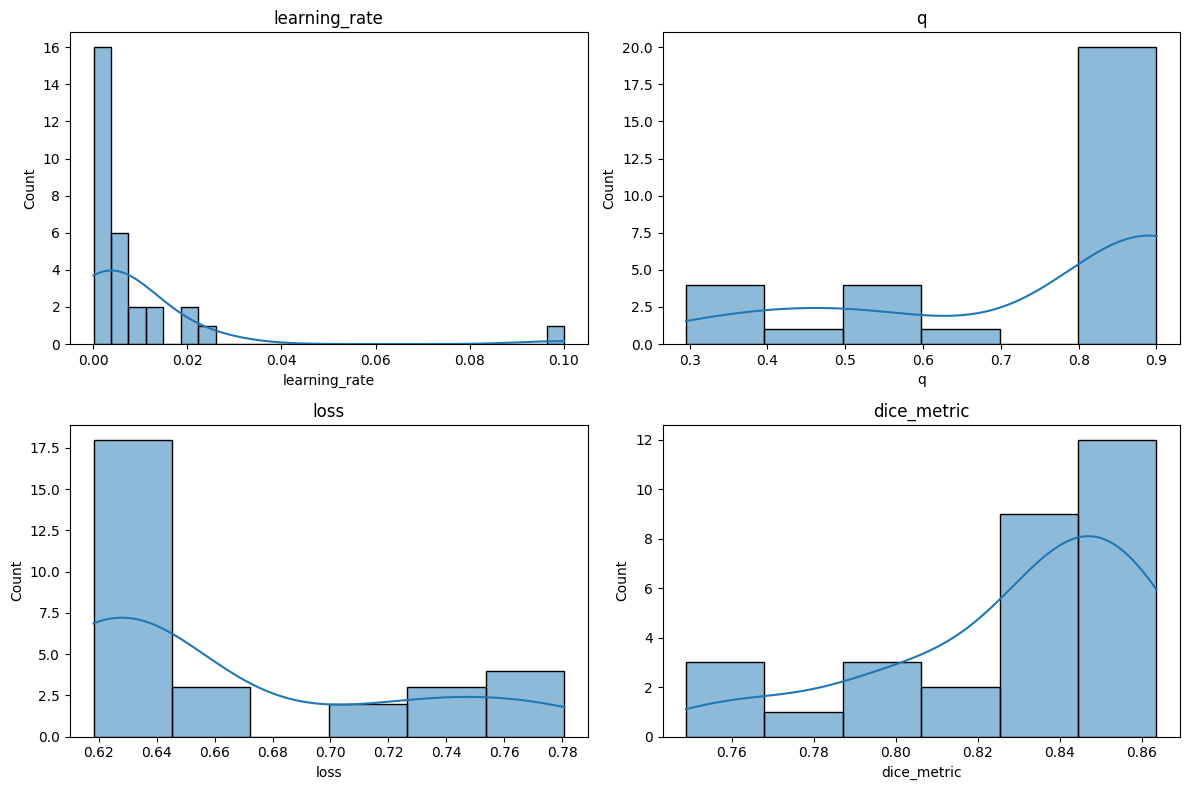

In [36]:
# Plots the distributions
plt.figure(figsize=(12, 8))
for i, column in enumerate(hp_df.columns[1:]):
    plt.subplot(2, 2, i+1)
    sns.histplot(hp_df[column], kde=True)
    plt.title(column)

plt.tight_layout()
plt.show()

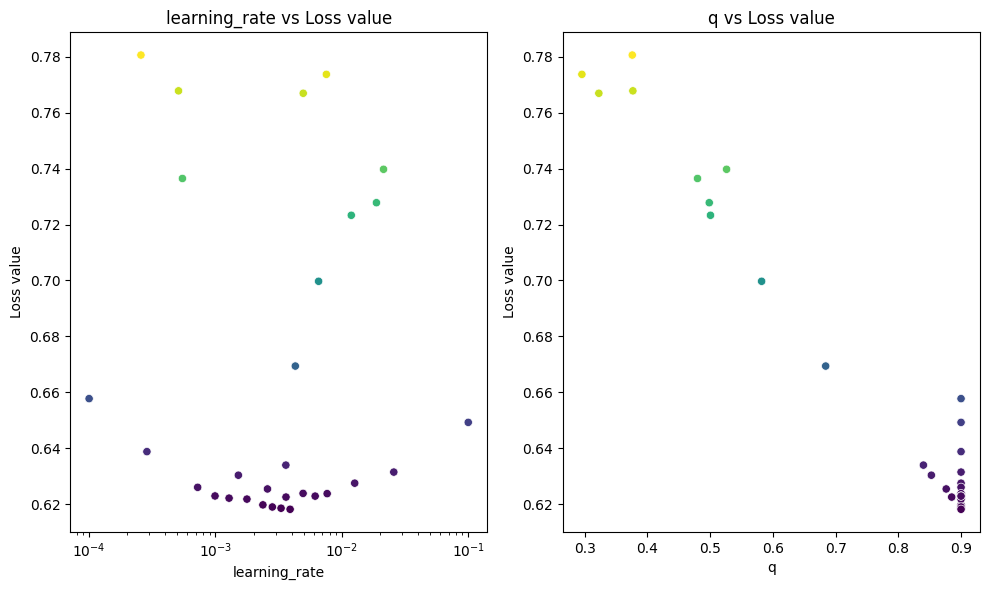

In [37]:
columns_to_log_scale = ['learning_rate']
# Plot hyperparameters values vs loss value
fig,axes = plt.subplots(1, 2, figsize=(10, 6))

# Iterate over each subplot and the corresponding scatterplot is created.
for (column, ax) in zip(hp_df.iloc[:, 1:4], axes.flatten()):
    sns.scatterplot(x=hp_df[column], y=hp_df['loss'], hue=hp_df['loss'], palette='viridis', ax=ax, legend=False)
    ax.set_xlabel(column)
    if hp_df[column].name in columns_to_log_scale:
        ax.set_xscale('log')
    ax.set_ylabel('Loss value')
    ax.set_title(f'{column} vs Loss value')
    
# Adjust the design and show the figure
plt.tight_layout()
plt.show()

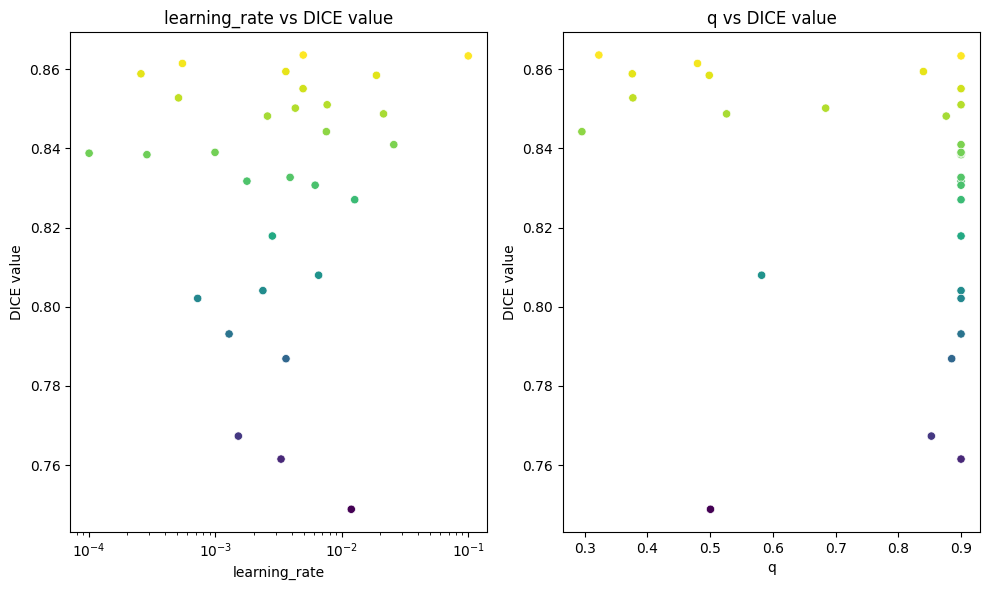

In [38]:
columns_to_log_scale = ['learning_rate']
# Plot hyperparameters values vs loss value
fig,axes = plt.subplots(1, 2, figsize=(10, 6))

# Iterate over each subplot and the corresponding scatterplot is created.
for (column, ax) in zip(hp_df.iloc[:, 1:4], axes.flatten()):
    sns.scatterplot(x=hp_df[column], y=hp_df['dice_metric'], hue=hp_df['dice_metric'], palette='viridis', ax=ax, legend=False)
    ax.set_xlabel(column)
    if hp_df[column].name in columns_to_log_scale:
        ax.set_xscale('log')
    ax.set_ylabel('DICE value')
    ax.set_title(f'{column} vs DICE value')
    
# Adjust the design and show the figure
plt.tight_layout()
plt.show()

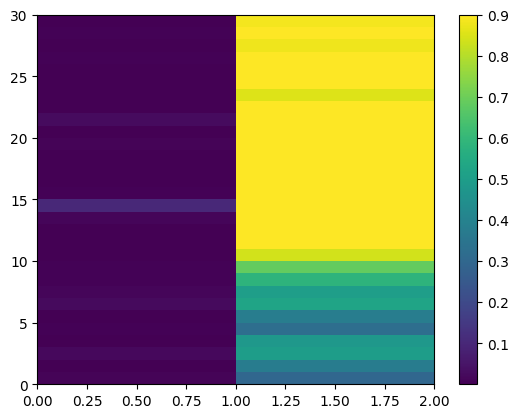

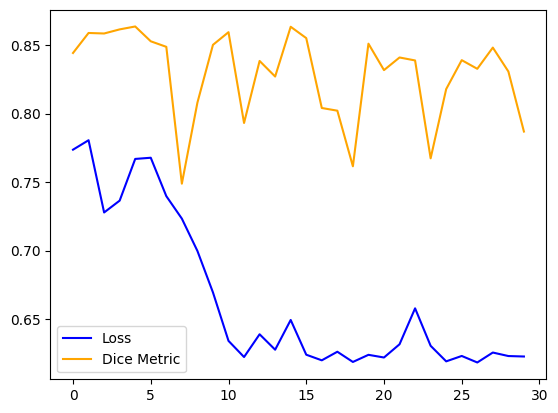

In [40]:
# Plot a heatmap of the learning rate and q hyperparameters
plt.pcolormesh(hp_df[['learning_rate', 'q']].values)
plt.colorbar()  # Add a colorbar 
plt.show()

# Plot the loss values over trials
plt.plot(hp_df['loss'].values, label='Loss', linestyle='-', color='blue')

# Plot the dice metric values over trials
plt.plot(hp_df['dice_metric'].values, label='Dice Metric', linestyle='-', color='orange')

# Add a legend to differentiate between the loss and dice metric plots
plt.legend()

# Display the line plots
plt.show()

## Predictive GPR trained for the search space using hyperparameter probabilities as embeddings

In [49]:
# Call the _vectorize_trials method from the tuner oracle
# This method converts the hyperparameter configurations of trials into vector representations (X)
# and pairs these vectors with their corresponding performance scores (y)
X, y = tuner.oracle._vectorize_trials()

In [50]:
# Generate 300 points evenly spaced between the minimum and maximum values of the first feature in X
# Add a small buffer (0.00003) to the minimum and maximum to avoid edge effects
hp_1 = np.linspace(X[:,0].min() - 0.00003, X[:,0].max() + 0.00003, 300)

# Generate 300 points evenly spaced between the minimum and maximum values of the second feature in X
# Add a small buffer (0.00003) to the minimum and maximum to avoid edge effects
hp_2 = np.linspace(X[:,1].min() - 0.00003, X[:,1].max() + 0.00003, 300)

In [51]:
# Create a meshgrid for the input space
Xx, Yy = np.meshgrid(hp_1, hp_2)

# Stack the meshgrid arrays to create the input for prediction
XY = np.vstack([Xx.ravel(), Yy.ravel()]).T

# Make predictions using the Gaussian Process model
mean, std = gp.predict(XY, return_std=True)  

# Reshape the predictions to match the shape of the meshgrid
mean = mean.reshape(Xx.shape)
std = std.reshape(Xx.shape)

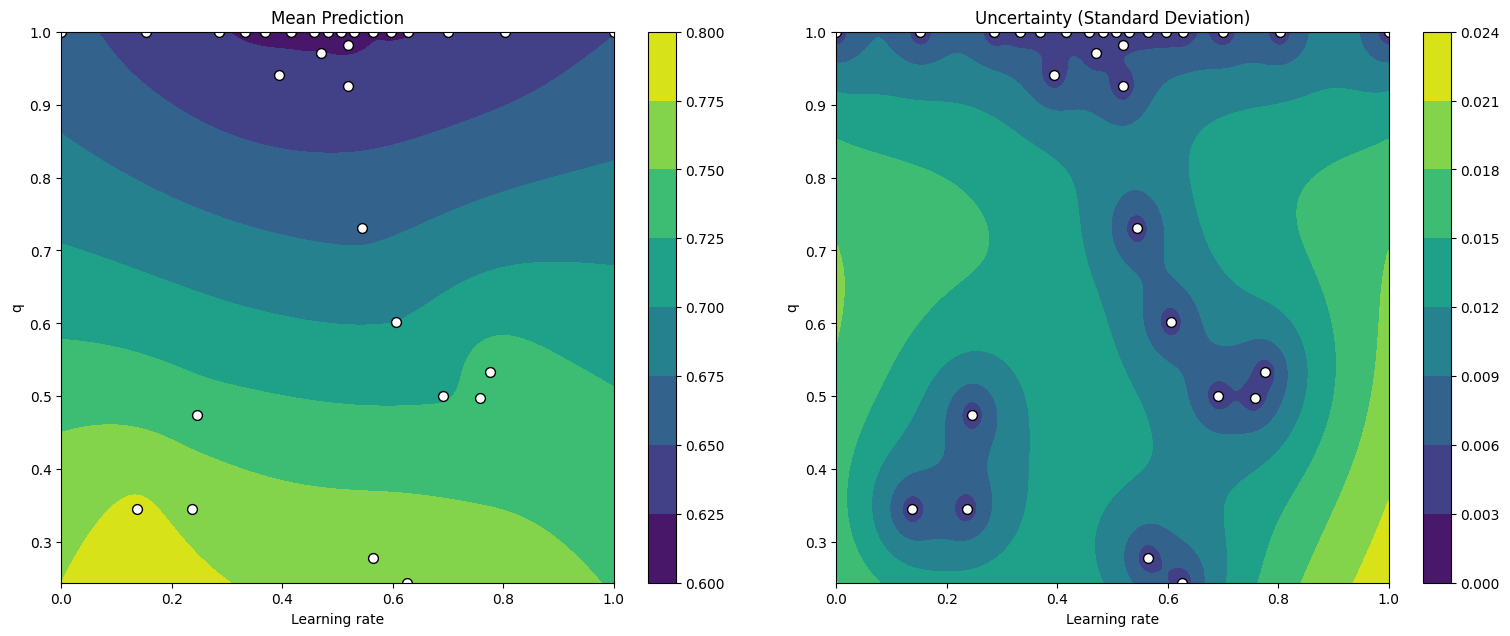

In [52]:
# Plot the results
plt.figure(figsize=(16, 7))

# Heatmap of the mean prediction
plt.subplot(1, 2, 1)
plt.title('Mean Prediction') 
plt.xlabel('Learning rate')
plt.ylabel('q')  
# Plot the heatmap of the mean prediction using contourf
heatmap1 = plt.contourf(hp_1, hp_2, mean, cmap='viridis', aspect='auto')  # Adjust the axis scaling
plt.colorbar(heatmap1)  # Add a colorbar 
plt.scatter(X[:, 0], X[:, 1], c='white', s=50, edgecolors='k') # Scatter plot of the data points in white with black edges

# Heatmap of the uncertainty (standard deviation)
plt.subplot(1, 2, 2)
plt.title('Uncertainty (Standard Deviation)')
plt.xlabel('Learning rate')
plt.ylabel('q')
# Plot the heatmap of the standard deviation using contourf
heatmap2 = plt.contourf(hp_1, hp_2, std, cmap='viridis', aspect='auto')  # Adjust the axis scaling
plt.colorbar(heatmap2)  # Add a colorbar
plt.scatter(X[:, 0], X[:, 1], c='white', s=50, edgecolors='k') # Scatter plot of the data points in white with black edges

# Adjust the spacing between subplots to prevent overlap
plt.tight_layout(pad=3.0)
# Display the plots
plt.show()

## Visualizing the performance of the best model in a test image

In [54]:
# Get the best model found
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
top_trials = tuner.oracle.get_best_trials(1)

for trial in top_trials:
    print(f"Trial {trial.trial_id}: Learning rate: {trial.hyperparameters.get('learning_rate')}, Power of q: {trial.hyperparameters.get('q')}")

Trial 26: Learning rate: 0.003893799649123131, Power of q: 0.9


In [56]:
# Get model's prediction on test image
best_model_bayesian = tuner.get_best_models(num_models=1)[0]
prediction = best_model_bayesian.predict(X_test[123:124])

1/1 [==============================] - 1s 1s/step


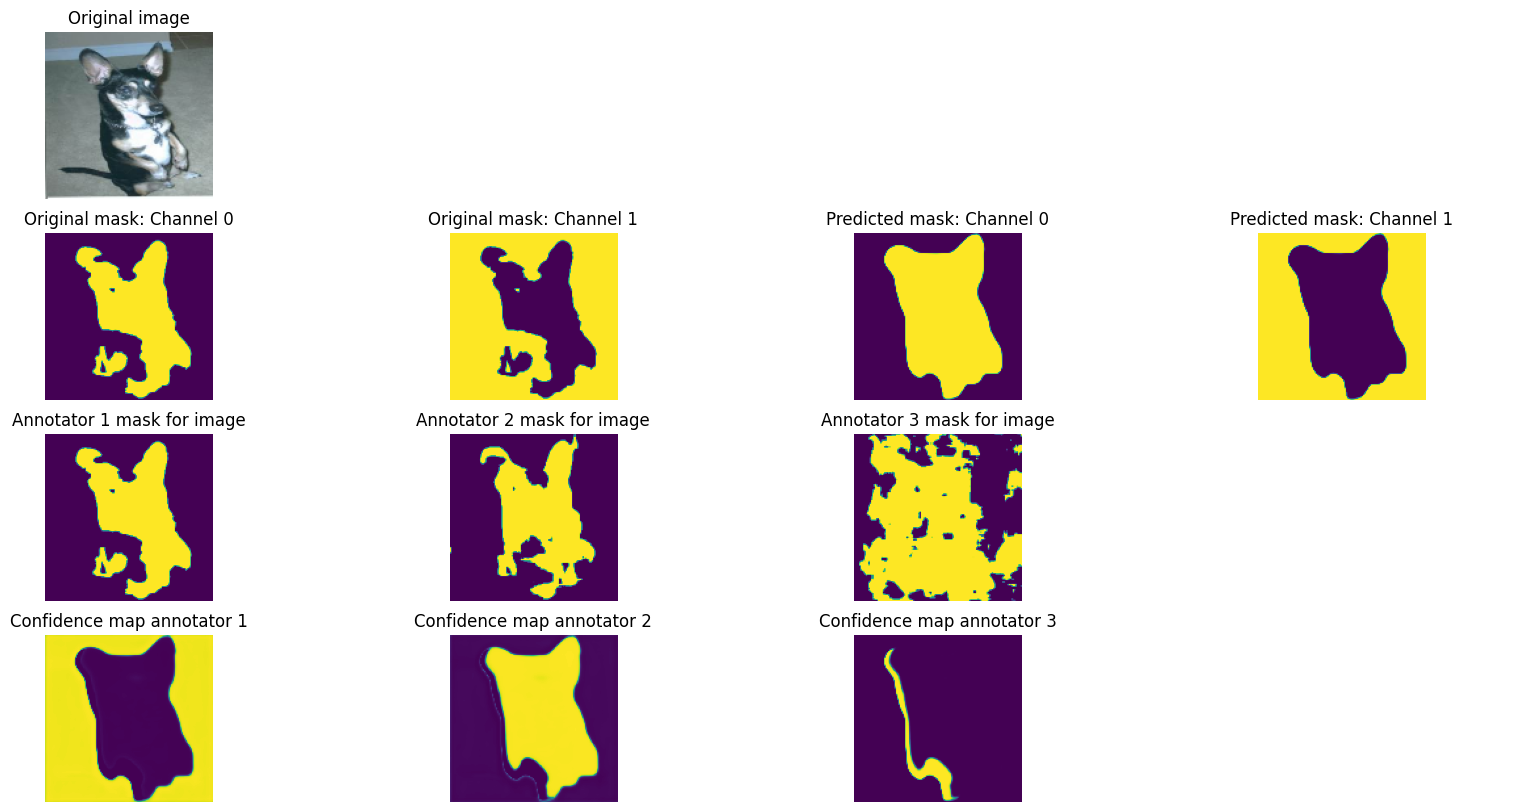

In [60]:
# Visualize the prediction
plot_prediction(prediction,X_test,y_test,123,3)

In [58]:
# Save model
best_model_bayesian.save('best_model_bayesian_sparsesoftmax.keras')